# Modeling and Simulation in Python

Chapter 20

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [120]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr'

# import functions from the modsim.py module
from modsim import *

### Exercises

**Exercise:** Here's a question from the web site [Ask an Astronomer](http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

"If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Use `run_ode_solver` to answer this question.

Here are some suggestions about how to proceed:

1.  Look up the Law of Universal Gravitation and any constants you need.  I suggest you work entirely in SI units: meters, kilograms, and Newtons.

2.  When the distance between the Earth and the Sun gets small, this system behaves badly, so you should use an event function to stop when the surface of Earth reaches the surface of the Sun.

3. Express your answer in days, and plot the results as millions of kilometers versus days.

If you read the reply by Dave Rothstein, you will see other ways to solve the problem, and a good discussion of the modeling decisions behind them.


You might also be interested to know that [it's actually not that easy to get to the Sun](https://www.theatlantic.com/science/archive/2018/08/parker-solar-probe-launch-nasa/567197/).

In [141]:
# units!
year = UNITS.year
s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter
AU = UNITS.astronomical_unit;

In [145]:
x_0 = (0 * AU).to_base_units()
y_0 = (1 * AU).to_base_units()

vx_0 = 30330 * m / s
vy_0 = 0 * m / s

init = State(x=x_0,
             y=y_0,
             vx=vx_0,
             vy=vy_0)

In [147]:
system = System(init=init,
                G=6.674e-11 * N / kg ** 2 * m ** 2,
                m_sun=1.99e30 * kg,
                m_earth=5.972e24 * kg,
                t_end=100e6 * s,
                r_final=695.508e6 * m + 6.371e6 * m)

In [151]:
def universal_grav(state, system):
    """Calculates gravitational force for arbitrary objects"""
    x, y, vx, vy = state
    unpack(system)
  
    position = Vector(x, y)
  
    mag = G * m_sun * m_earth / position.mag ** 2
    direction = -position.hat()
  
    force = direction * mag
    
    return force
  

In [149]:
def slope_func(state, t, system):
    x, y, vx, vy = state
    unpack(system)
  
    v = Vector(vx, vy)
    force = universal_grav(state, system)
    a = force / m_earth
    
    return vx, vy, a.x, a.y

In [152]:
vx, vy, ax, ay = slope_func(init, 0, system)
print(vx, vy, ax, ay)

30330.0 meter / second 0.0 meter / second -0.0 newton / kilogram -0.005934559038759181 newton / kilogram


In [153]:
def event_func(state, t, system):
    x, y, vx, vy = state
    position = Vector(x, y)
    return position.mag - system.r_final

In [154]:
event_func(init, 0, system)

<Quantity(148895991691.0, 'meter')>

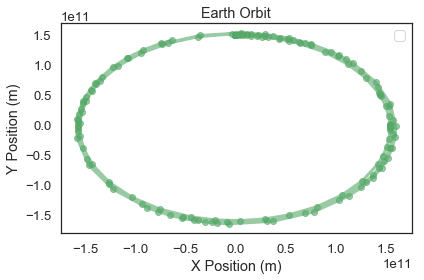

In [165]:
results, details = run_ode_solver(system, slope_func, method='LSODA')
results.index /= 60 * 60 * 24
# results.r *= (0.000621371 / 1000)
plot(results.x, results.y, 'go-')
decorate(title='Earth Orbit',
         xlabel='X Position (m)',
         ylabel='Y Position (m)')

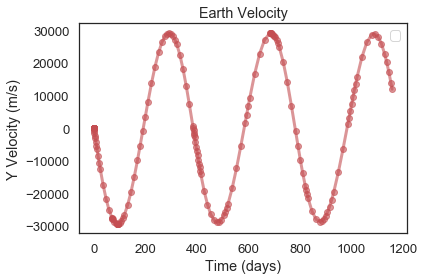

In [167]:
plot(results.vy, 'ro-')
decorate(title='Earth Velocity',
         xlabel='Time (days)',
         ylabel='Y Velocity (m/s)')

In [168]:
x_0 = (0 * AU).to_base_units()
y_0 = (1 * AU).to_base_units()

vx_0 = 0 * m / s
vy_0 = 0 * m / s

init = State(x=x_0,
             y=y_0,
             vx=vx_0,
             vy=vy_0)

In [169]:
system = System(init=init,
                G=6.674e-11 * N / kg ** 2 * m ** 2,
                m_sun=1.99e30 * kg,
                m_earth=5.972e24 * kg,
                t_end=100e6 * s,
                r_final=695.508e6 * m + 6.371e6 * m)

In [174]:
def event_func(state, t, system):
    x, y, vx, vy = state
    position = Vector(x, y)
    return position.mag

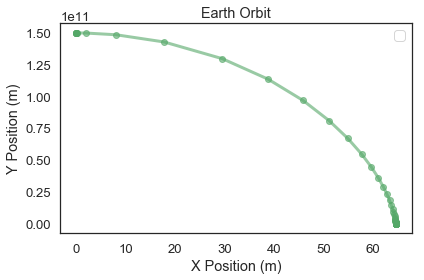

In [180]:
results, details = run_ode_solver(system, slope_func, events=event_func, method='RK23')
results.index /= 60 * 60 * 24
# results.r *= (0.000621371 / 1000)
plot(results.y, 'go-')
decorate(title='Earth Orbit',
         xlabel='X Position (m)',
         ylabel='Y Position (m)')

In [ ]:
# # Imports
# from IPython.display import clear_output
# import os
# import time

# # Install Python libraries
# !pip3 install pandas seaborn sympy beautifulsoup4 lxml pint scipy==1.1.0 numpy

# # Removes code before re-downloading it
# !rm -rf ./ModSimPy
# !rm -rf ./modsim.py

# # Grabs ModSimPy
# !git clone https://github.com/AllenDowney/ModSimPy.git
# !cp "ModSimPy/code/modsim.py" .

# # Resets kernel to flush outdated libraries (especially SciPy)
# clear_output()
# print("Configured for ModSimPy. Restarting kernel.")
# time.sleep(1)
# os._exit(0)